In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2


In [2]:
train_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\dataset"
validation_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\Split\\validasi"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# Load data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 163 images belonging to 12 classes.


In [6]:
# Data validasi hanya dengan preprocessing (tanpa augmentasi)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load data validasi
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)


Found 720 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

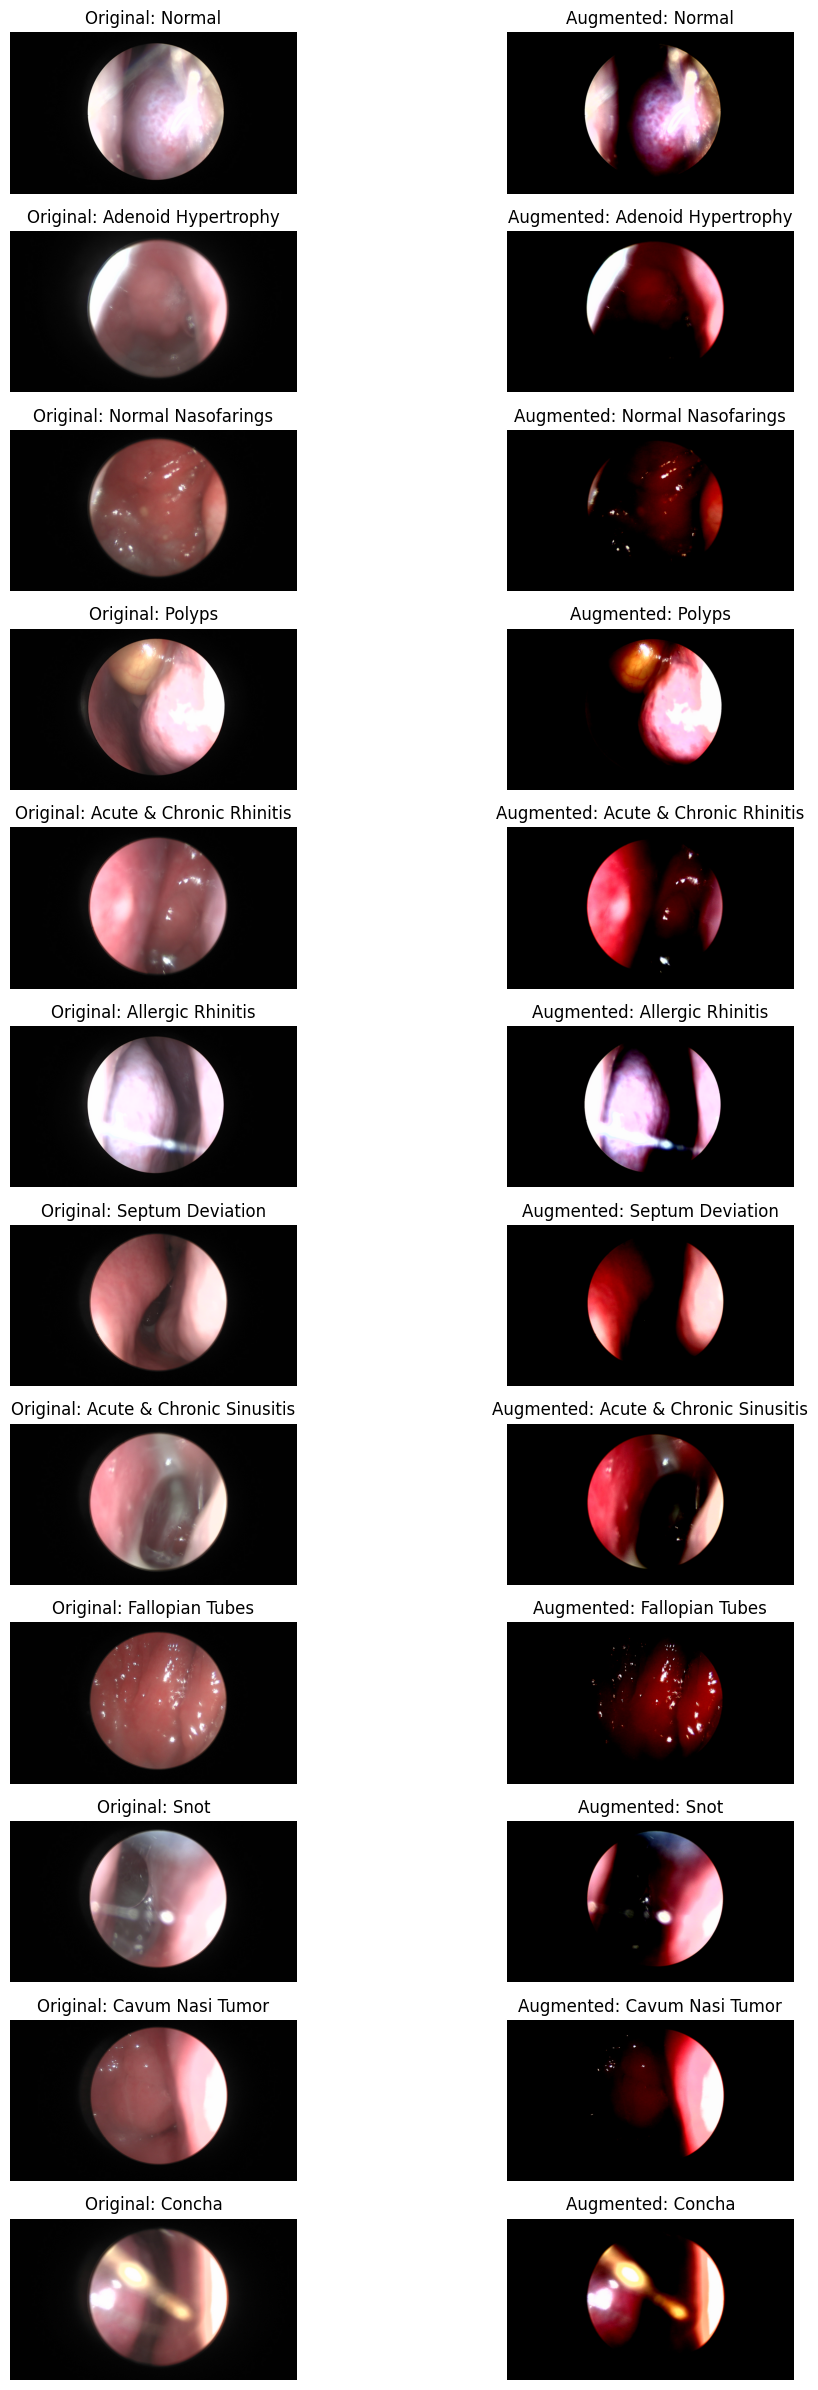

In [7]:
# Nama kelas
classes = ['Normal', 'Adenoid Hypertrophy', 'Normal Nasofarings', 'Polyps', 'Acute & Chronic Rhinitis', 'Allergic Rhinitis', 'Septum Deviation', 'Acute & Chronic Sinusitis', 'Fallopian Tubes', 'Snot', 'Cavum Nasi Tumor', 'Concha']

# Plot untuk menampilkan hasil
plt.figure(figsize=(12, 24))

for idx, class_name in enumerate(classes):
    # Ambil satu gambar dari setiap kelas
    class_dir = os.path.join(train_dir, class_name)
    image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Gambar pertama di kelas tersebut
    
    # Load gambar
    original_image = load_img(image_path)  # PIL image
    original_image_array = img_to_array(original_image)  # Numpy array
    original_image_array = original_image_array[np.newaxis, ...]  # Tambahkan batch dimension
    
    # Generator augmentasi
    augmented_images = train_datagen.flow(original_image_array, batch_size=1)
    augmented_image = next(augmented_images)[0]  # Hasil augmentasi pertama
    
    # Tampilkan gambar asli
    plt.subplot(len(classes), 2, idx * 2 + 1)
    plt.imshow(original_image)
    plt.title(f"Original: {class_name}")
    plt.axis("off")
    
    # Tampilkan hasil augmentasi
    plt.subplot(len(classes), 2, idx * 2 + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
# Load MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.005)),  # L2 regularization
    BatchNormalization(),
    Dropout(0.5),  # Dropout
    Dense(128, activation="relu", kernel_regularizer=l2(0.003)),  # L2 regularization
    BatchNormalization(),
    Dropout(0.4),  # Dropout
    Dense(12, activation="softmax")
])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,900 (10.00 MB)

 Trainable params: 363,148 (1.39 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [10]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=5e-4),  # Learning rate kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Callbacks
filepath = 'C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\model\\MobNetV2.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_lr=1e-6,verbose=1)
callback_list = [checkpoint, reduce_lr]

In [12]:
# Melatih model dan menyimpan history
history = model.fit(
    train_generator,
    epochs=50,  # Sesuaikan jumlah epoch
    validation_data=validation_generator,
    callbacks=callback_list
)

Epoch 1/50


c:\Users\asusm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.0462 - loss: 6.5392
Epoch 1: val_loss improved from inf to 5.32561, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\MobNetV2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.0484 - loss: 6.5318 - val_accuracy: 0.1042 - val_loss: 5.3256 - learning_rate: 5.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.1150 - loss: 5.6698
Epoch 2: val_loss improved from 5.32561 to 5.25190, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\MobNetV2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.1170 - loss: 5.6682 - val_accuracy: 0.1097 - val_loss: 5.2519 - learning_rate: 5.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1746 - loss: 5.2803
Epoch 3: val_loss improved from 5.25190 to 5.22405, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\MobNetV2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.1777 - loss: 5.2663 - val_accuracy: 0.1208 - v

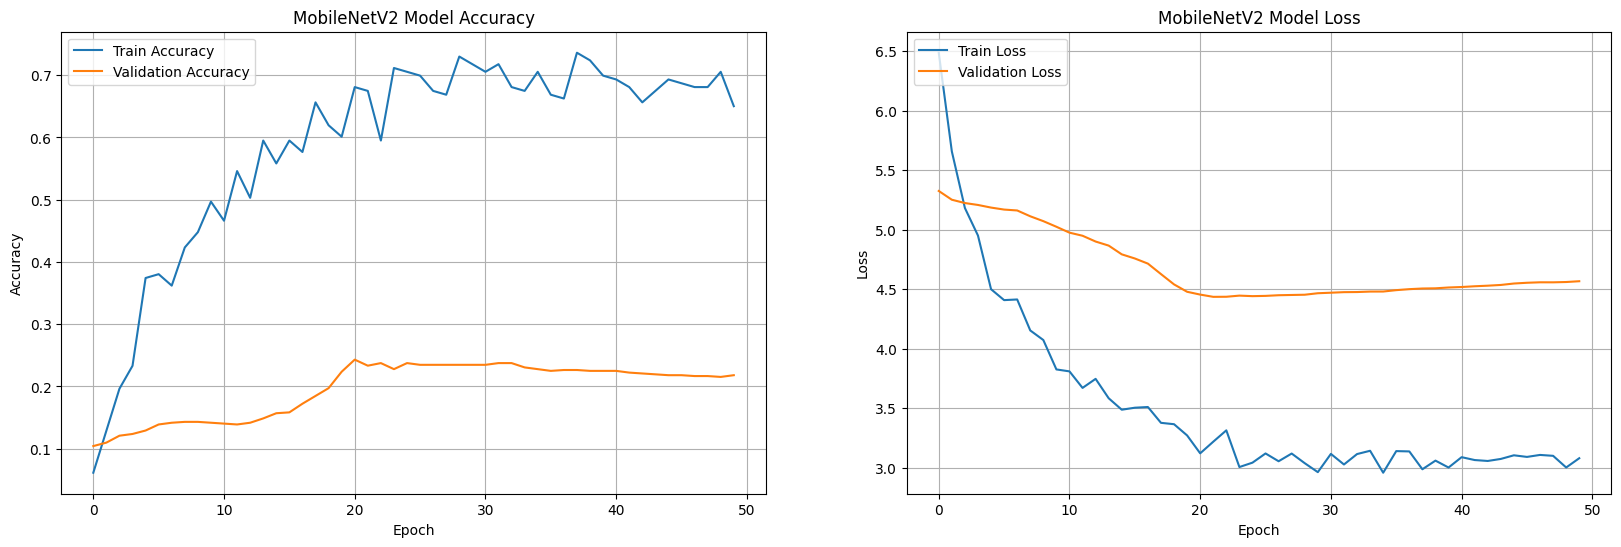

In [13]:
# Plotting accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('MobileNetV2 Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('MobileNetV2 Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

Found 360 images belonging to 12 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.9631 - loss: 0.2660
Loss: 0.25275012850761414
Accuracy: 0.9666666388511658
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step

Metrics using sklearn:
Accuracy: 0.9666666666666667
Precision: 0.9688819920727922
Recall: 0.9666666666666667
F1 Score: 0.966987450591523

Classification Report:
                           precision    recall  f1-score   support

 Acute & Chronic Rhinitis       1.00      0.93      0.97        30
Acute & Chronic Sinusitis       1.00      1.00      1.00        30
      Adenoid Hypertrophy       0.97      0.93      0.95        30
        Allergic Rhinitis       0.88      1.00      0.94        30
         Cavum Nasi Tumor       0.97      0.93      0.95        30
                   Concha       1.00      0.97      0.98        30
          Fallopian Tubes       1.00      1.00      1.00        30
                   Normal       0.88      0.97      0.92        30
       Normal Nasofar

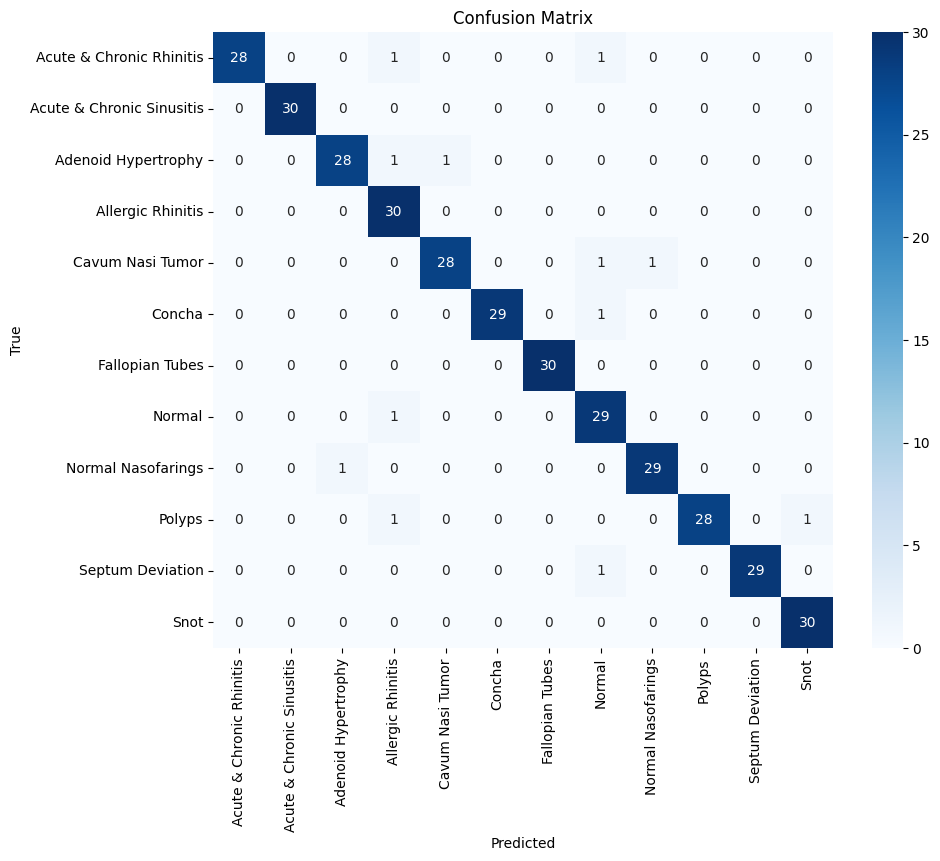

In [14]:
# Path ke model yang disimpan
model_path = 'C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\model\\MobileNetV2Aug.keras'

# Memuat model
model = load_model(model_path)

# Path ke direktori dataset
test_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\Split\\uji"

# Membuat objek ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = ImageDataGenerator(rescale=1.0/255)


# Load data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Pastikan shuffle dinonaktifkan untuk menjaga urutan data
)

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)

# Selesai menghitung waktu
end_time = time.perf_counter()

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Menghitung prediksi untuk data uji
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya dari test_generator
y_true = test_generator.classes

# Mendapatkan label class dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung metrik menggunakan sklearn
accuracy_sklearn = accuracy_score(y_true, y_pred)
precision_sklearn = precision_score(y_true, y_pred, average='weighted')
recall_sklearn = recall_score(y_true, y_pred, average='weighted')
f1_sklearn = f1_score(y_true, y_pred, average='weighted')

print("\nMetrics using sklearn:")
print(f"Accuracy: {accuracy_sklearn}")
print(f"Precision: {precision_sklearn}")
print(f"Recall: {recall_sklearn}")
print(f"F1 Score: {f1_sklearn}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
